<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/jonasnylund/Lab-3/jonasnylund_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Jonas Nylund**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [5]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.


'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

import numpy as np
from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

In [0]:
def gen_mesh(L=4, H=4, xc=1, yc=2, resolution=16):
  global rc, mesh
  # Define circle
  rc = 0.2

  # Generate mesh (examples with and without a hole in the mesh) 
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)


**Define finite element approximation spaces**

In [0]:
def gen_fem(approx_diff=1):
  global W,V,Q, w,u,p,v,q, va,qa, wa,phi,theta,va,qa

  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 2+approx_diff)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 1+approx_diff)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)


**Define boundary conditions**

In [0]:
def gen_bc():
  global ib,ob,wb,bb, uin
  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

**Define and solve variational problems**

In [0]:
def gen_varProb(psi_1=("0.0", "0.0"), psi_2="0.0", psi_3=("1.0", "0.0")):
  global f, res, res_a, gamma

  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
  psi1 = Expression(psi_1, element = V.ufl_element())
  psi2 = Expression(psi_2, element = Q.ufl_element())
  phi3 = Expression(psi_3, element = V.ufl_element())

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system 
  solve(res == 0, w) 

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system 
  solve(res_a == 0, wa) 

**Visualize solution and export files**

In [0]:
def visualize(regular=False, adjoint=True):

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  """
  !rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn
  """


  if(regular):
    # Plot solution
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot(u_fcn, title="Velocity")

    plt.subplot(1,2,2)
    plot(p_fcn, title="Pressure")
    plt.show()

  if(adjoint):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot(phi_fcn, title="Adjoint velocity")

    plt.subplot(1,2,2)
    plot(theta_fcn, title="Adjoint pressure")
    plt.show()

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

**Compute error indicators**

In [0]:
def refine_mesh():
  global mesh

  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)


  # Compute local error indicators over the cells of the mesh 
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
  
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()] 
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)


def calcError():

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)

  return tot_err

#**Varying the domain**
When moving the circle over the domain, we see that the adjoint solution "follows" the circle. We notice the adjoint velocity forms two vortices, flowing together through the center of the circle and diverging in the wake of the circle, flowing around and converging again in front of the circle.
As the circle moves towards the lower edge of the domain, the velocity field moves towards the other edge, and the adjoint velocity largel follows. At the same time, the high pressure zone in front of the circle and low pressure zone begind it moves away from the boundary as the circle moves, but the adjoint high and low-pressure zones does the opposite, and moves towards the boundary.

The mesh refinement also "follows" the circle around. Mesh refinement happens where the gradient of the adjoint velocity and pressure is high, which seems resonable.

Center of circle: ( 0.5 0.5 )


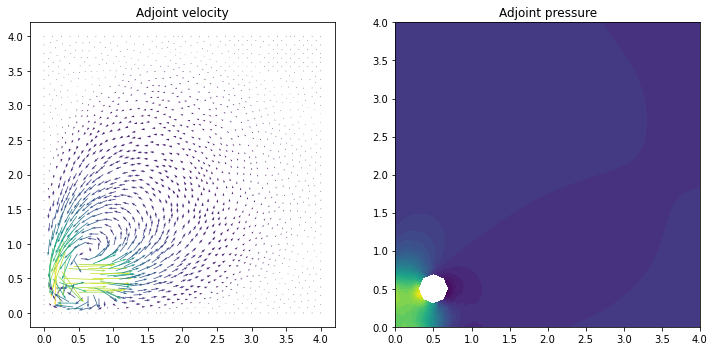

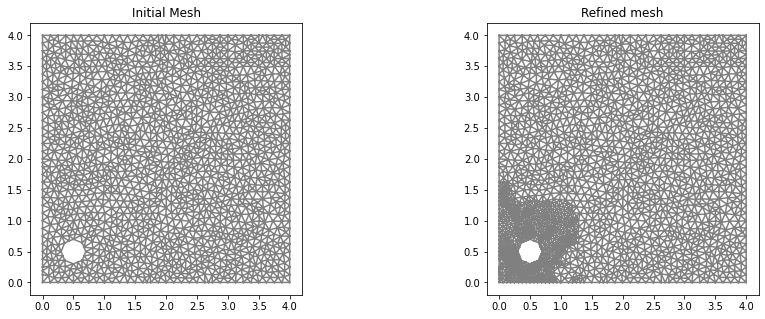

Center of circle: ( 0.5 1.5 )


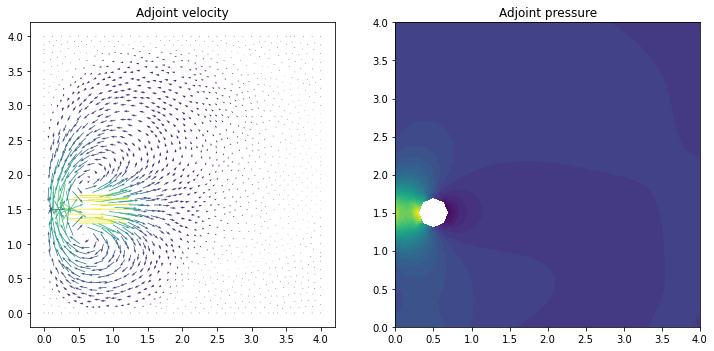

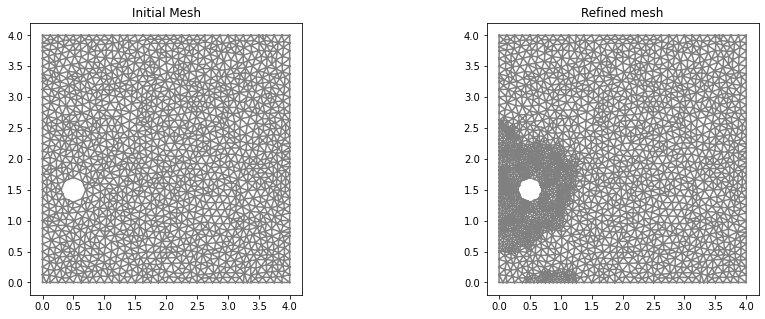

Center of circle: ( 1.5 0.5 )


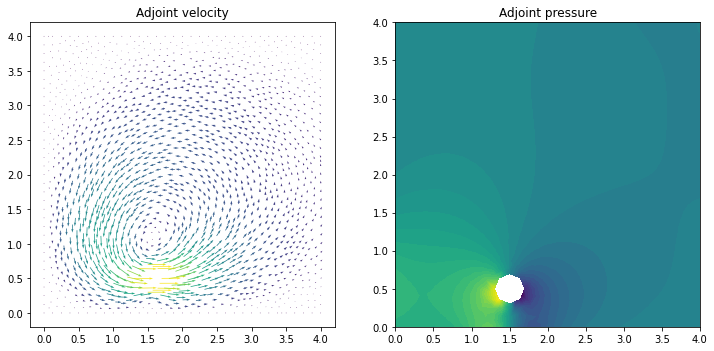

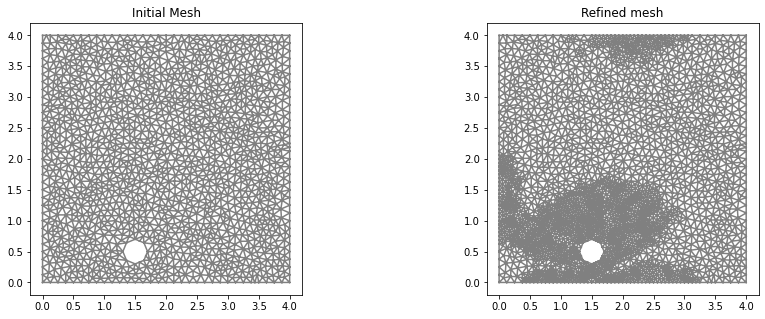

Center of circle: ( 1.5 1.5 )


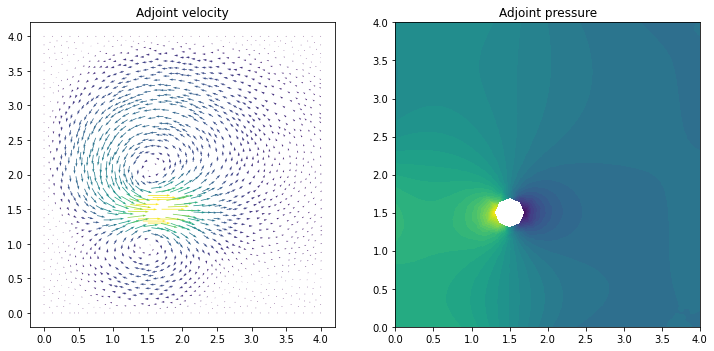

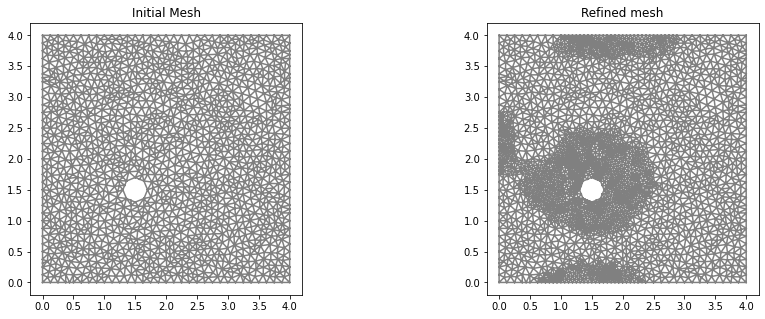

Center of circle: ( 2.5 0.5 )


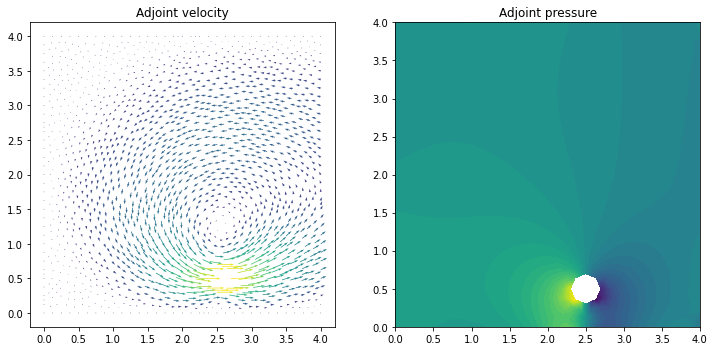

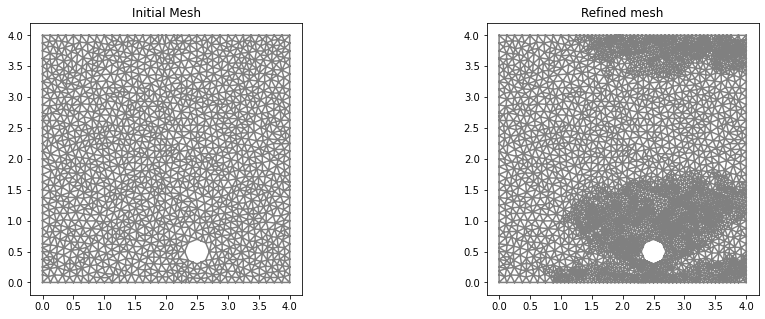

Center of circle: ( 2.5 1.5 )


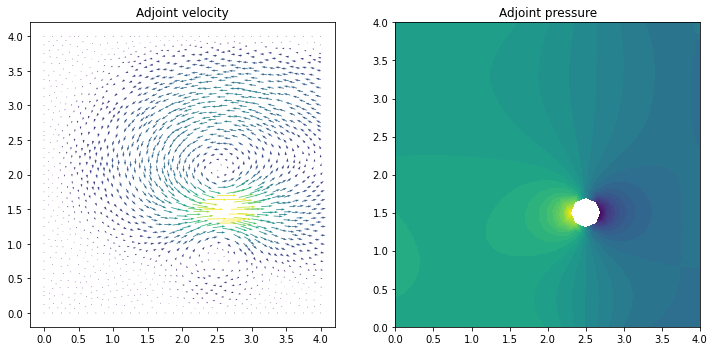

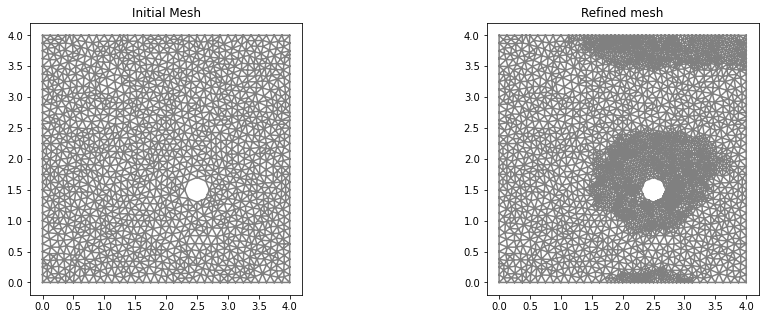

Center of circle: ( 3.5 0.5 )


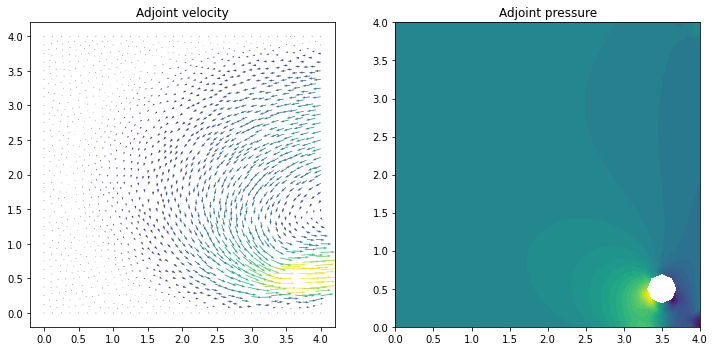

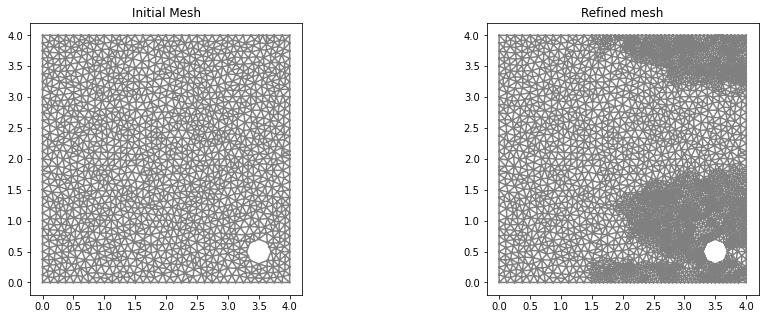

Center of circle: ( 3.5 1.5 )


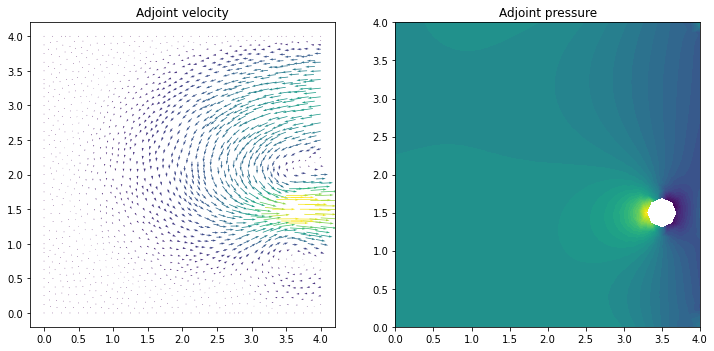

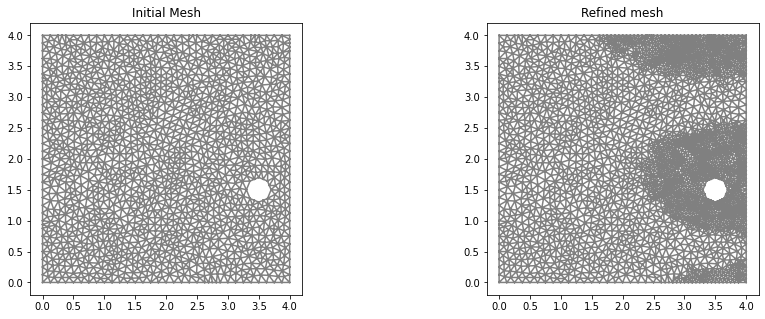

In [13]:

L=4
H=4


for xc in np.arange(0.5, L):
  for yc in np.arange(0.5, H/2):
    gen_mesh(L=L, H=H, xc=xc, yc=yc, resolution=32)

    gen_fem()
    gen_bc()
    gen_varProb()

    print("="*100)
    print("Center of circle: (",xc,yc, ")")
    visualize()

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1, title="Initial Mesh")
    plot(mesh)
    refine_mesh()
    plt.subplot(1,2,2, title="Refined mesh")
    plot(mesh)
    plt.show()
    

#**Varying the adjoint input data**
Change the data to the adjoint problem (psi_1, psi_2, psi_3) and describe how the adjoint solution and the local mesh refinement changes as a result. 

From my understanding of the definitions, the three parameters correspond to the folloing;

psi_1 Corresponds to the overall flow velocity in the volume, where a value of (x,y) means tendency for flow in this direction in an undisturbed domain.

psi_2 is the divergence in the adjoint problem, where positive values denotes a sink where the pressure is high, and negative values a source with high pressure.

psi_3 is the adjoint velocity on the boundary of the circle. 

Changing psi1 from (0,0) to (1,0) does not make much of a difference, since this biases the flow in the flow direction. psi1=(0,1) however biases the in the y-direction, which causes the mesh to be refined at the wall boundarys.

Changing psi2 to either positive or negative values, causes the adjoint solution to be more dependent to the divergence. This, together with changes to psi1 changes largely the adjoint velocity near the outflow boundary, since it encompasses a "do nothing" boundary condition. Hence, since the flow at the inflow boundary is fixed, any in-our outflow to satisfy the modified data to the adjoint problem needs to have the outflow boundary as "source".

As psi3 is changed from (1,0) to (0,1), means that the flow at the boundary of the circle will be in the y-direction, and the adjoint pressure gradient will also be in the y-axis. This causes the mesh refinement to focus more on the wall boundarys.





psi1: ('0.0', '0.0') , psi2: 0.0 , psi3: ('1.0', '0.0')


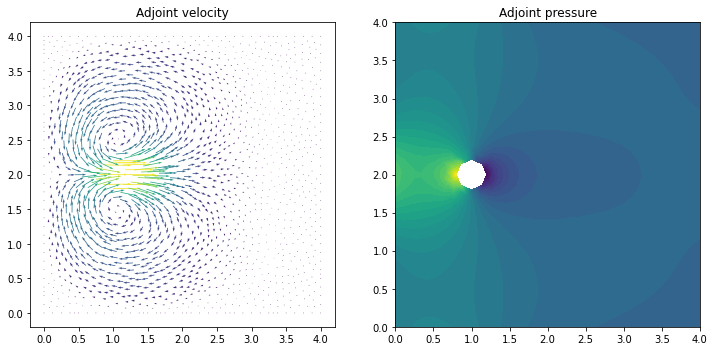

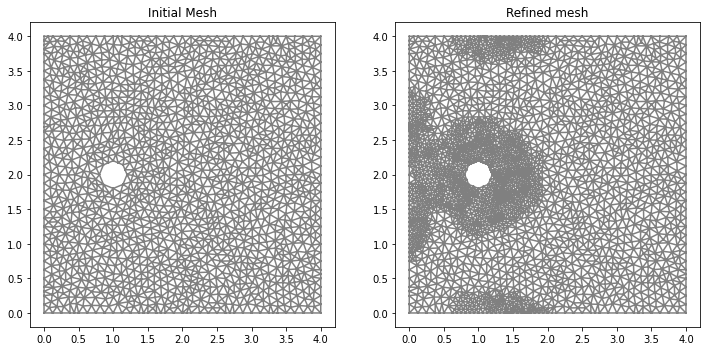

psi1: ('0.0', '0.0') , psi2: 0.0 , psi3: ('0.0', '1.0')


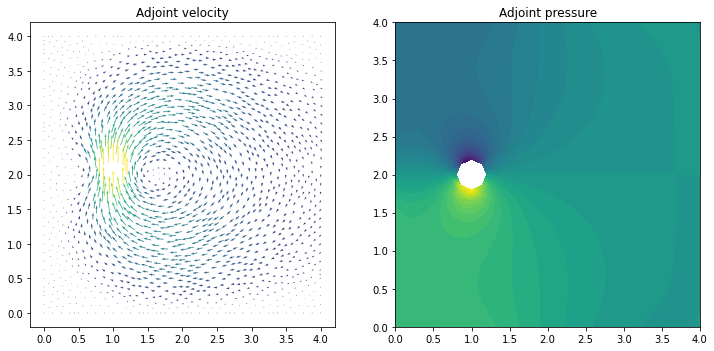

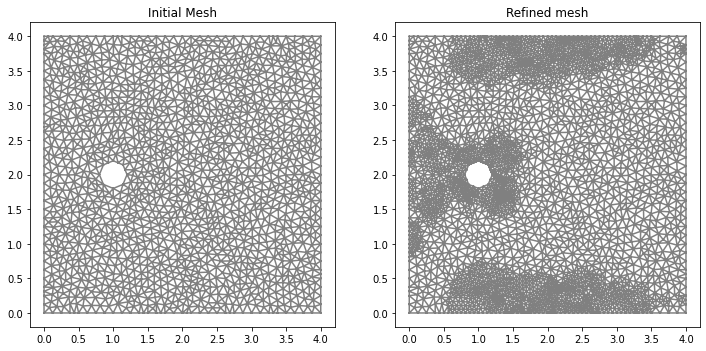

psi1: ('1.0', '0.0') , psi2: 0.0 , psi3: ('1.0', '0.0')


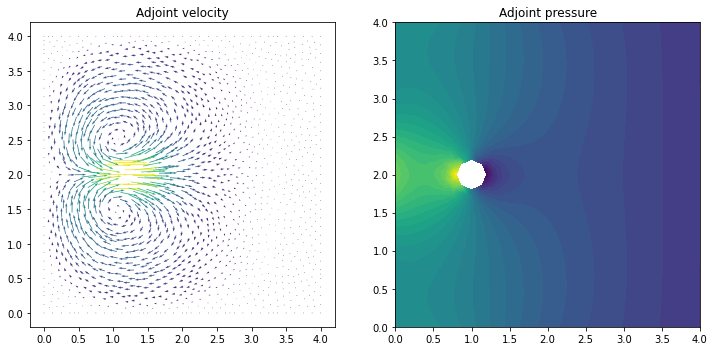

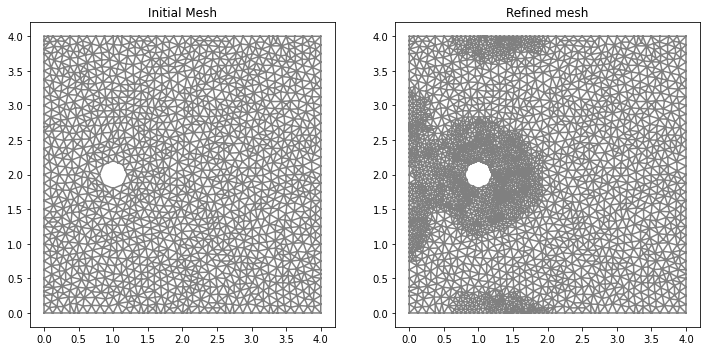

psi1: ('0.0', '1.0') , psi2: 0.0 , psi3: ('0.0', '1.0')


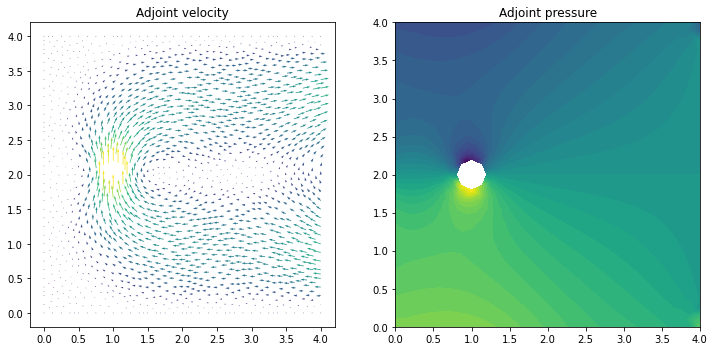

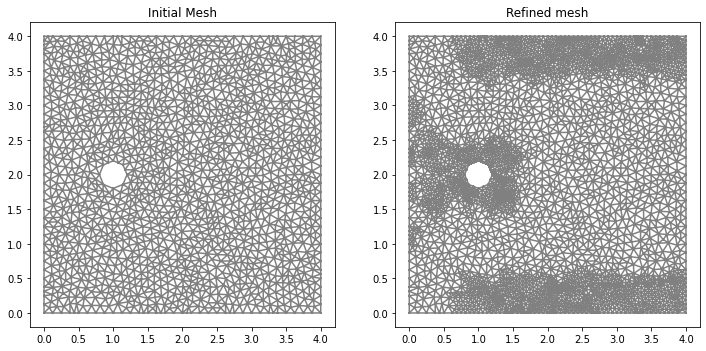

psi1: ('0.0', '1.0') , psi2: 0.0 , psi3: ('1.0', '0.0')


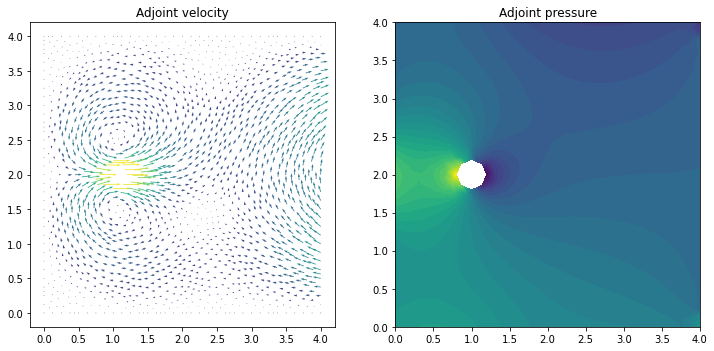

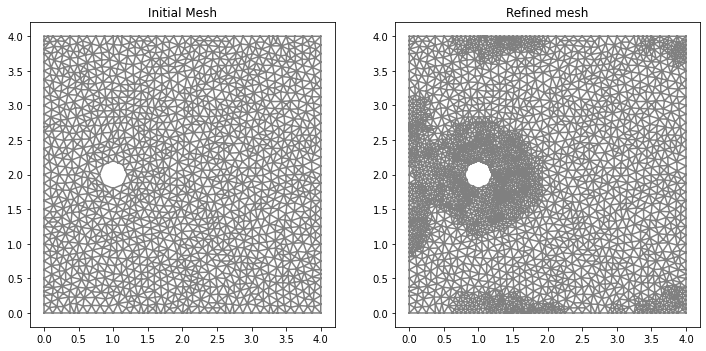

psi1: ('1.0', '0.0') , psi2: 0.0 , psi3: ('0.0', '1.0')


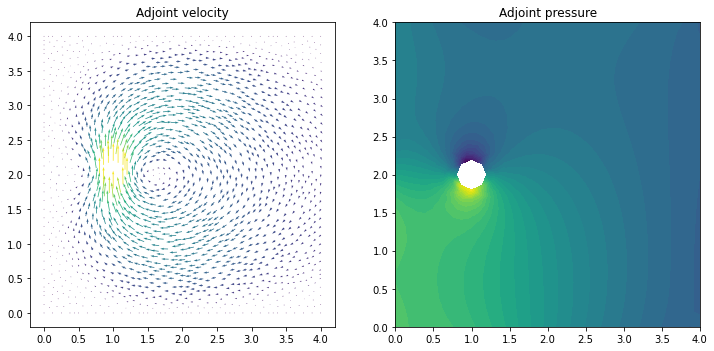

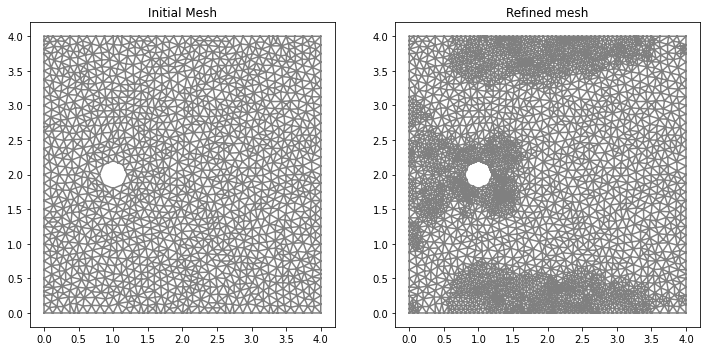

psi1: ('0.0', '0.0') , psi2: 1.0 , psi3: ('1.0', '0.0')


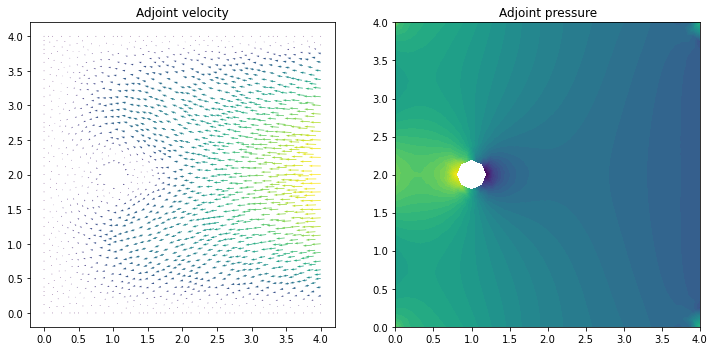

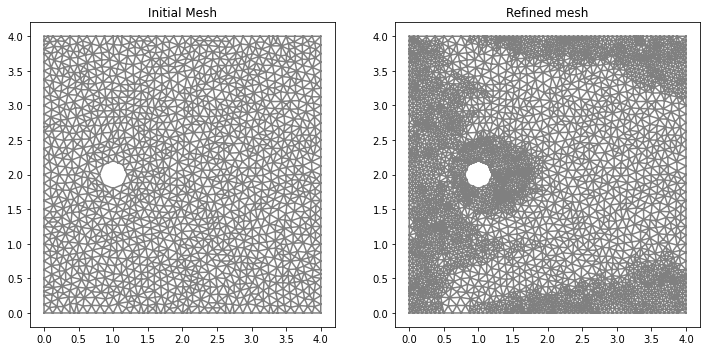

psi1: ('0.0', '0.0') , psi2: -1.0 , psi3: ('0.0', '1.0')


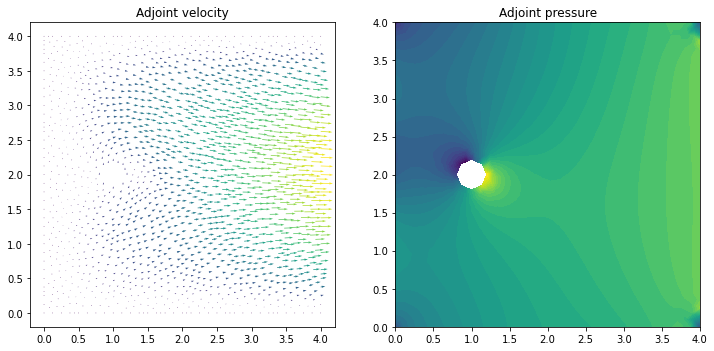

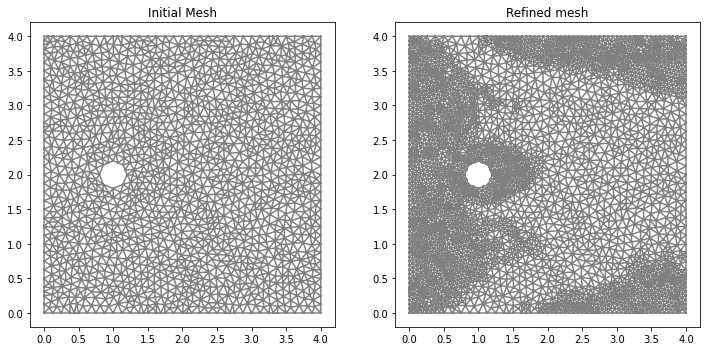

In [14]:
L=4
H=4

psi_1 = [("0.0","0.0")]*2 + [("1.0","0.0")] + [("0.0","1.0")]*2 + [("1.0","0.0")] +[("0.0","0.0")]*2
psi_2 = ["0.0"]*6 + ["1.0", "-1.0"]
psi_3 = [("1.0", "0.0"), ("0.0", "1.0")]*4 + [("1.0", "0.0")]*2

for (p1,p2,p3) in zip(psi_1, psi_2, psi_3):
  gen_mesh(L=L, H=H, resolution=32)
  print("="*100)
  print("psi1:", p1,", psi2:", p2,", psi3:", p3);

  gen_fem()
  gen_bc()
  gen_varProb(psi_1=p1, psi_2=p2, psi_3=p3)

  visualize()

  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1, title="Initial Mesh")
  plot(mesh)
  refine_mesh()
  plt.subplot(1,2,2, title="Refined mesh")
  plot(mesh)
  plt.show()

#**Total error**

Using the same approximation space for the adjoint solution incorrectly gives an error of 0. This is remedied by using a higher order approximation space for the adjoint solution.

Using a finer mesh gives a lower total error, as expected.

In [15]:
L=4
H=4
r = 16;

gen_mesh(L=L, H=H, resolution=r)
gen_fem(approx_diff=0)
gen_bc()
gen_varProb()
error = calcError()
print("Error with same approximation space:", round(error,5))

gen_fem(approx_diff=1)
gen_bc()
gen_varProb()
error = calcError()
print("Error with different approximation space:", round(error,5))

gen_mesh(L=L, H=H, resolution=r*2)
gen_fem(approx_diff=1)
gen_bc()
gen_varProb()
error = calcError()
print("Error with finer mesh:", round(error,5))

Error with same approximation space: -0.0
Error with different approximation space: 0.07867
Error with finer mesh: 0.01041


#**Adaptive mesh**

The mesh is iteratively refined by defining the adjoint problem, calculating the local cell error and refining the mesh in the nodes that have a higher than average error. After one pass, the solutions are recalculated and the errors updated.

While this is not a recursive algorithm, is does iteratively refine the mesh where the local error estimate is high.


Refining mesh, iteration  1


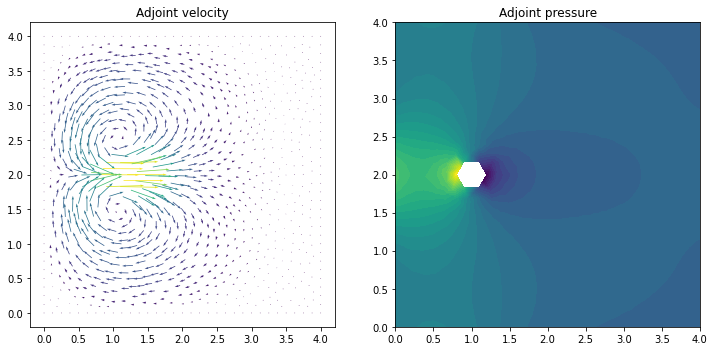

Error: 0.023
Refining mesh, iteration  2


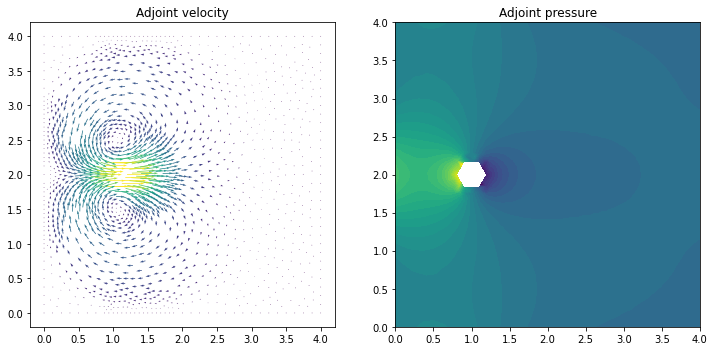

Error: 0.032
Refining mesh, iteration  3


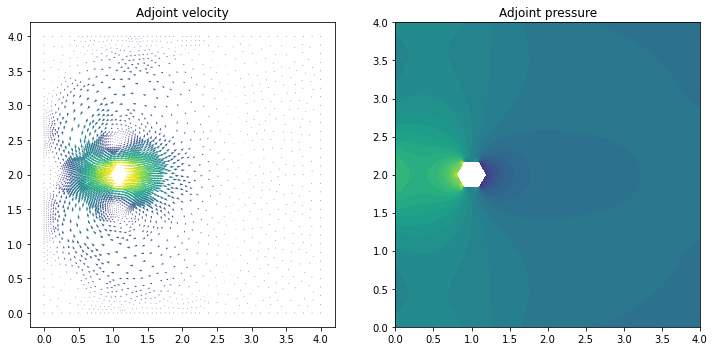

Error: 0.013
Refining mesh, iteration  4


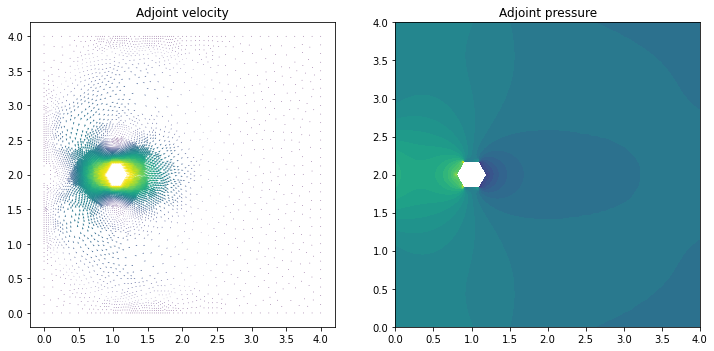

Error: 0.005



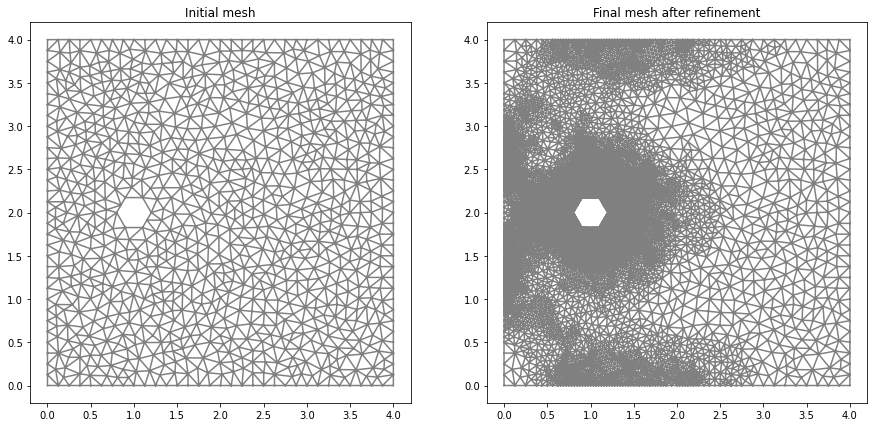

In [16]:
L=4
H=4
r = 24;

gen_mesh(L=L, H=H, resolution=r)

error = 1;
i=1;

## Iteratively refine the mesh, recalculating the adjoint solution between passes
while error > 0.01:
  print("="*100)
  print("Refining mesh, iteration ", i)

  ## FEM problem need to be redefined when the mesh is changed
  gen_fem()
  gen_bc()
  gen_varProb()
  visualize()
  ## Calculate the adjoint solution and refine the mesh where the error is high.
  refine_mesh()
  error = calcError()
  print("Error:", round(error,3))

  i+=1

print("="*100);
print()

plt.figure(figsize=(15,8))
plt.subplot(1,2,2, title="Final mesh after refinement")
plot(mesh)
plt.subplot(1,2,1, title="Initial mesh")
## Hack to compare initial mesh to final one. Just overwrite the thing!
gen_mesh(L=L, H=H, resolution=r)
plot(mesh)
plt.show();